# Chicago COVID mobility

In [2]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

### Features

In [3]:
df_features_census = pd.read_csv('./data/census_processed.csv')
df_features_census["geo_12"] = df_features_census["GEO_ID"].map(lambda x: str(x)[-12:])
df_features_census.drop(["GEO_ID"], axis=1, inplace=True)
df_features_census['geo_12'] = df_features_census['geo_12'].astype('int64')

In [4]:
df_features_places = pd.read_csv('./data/places_count_by_census_block.csv', dtype={'geo_12': 'str'})
df_features_places['geo_12'] = df_features_places['geo_12'].astype('int64')

In [5]:
df_features = df_features_places.merge(df_features_census, on='geo_12')
df_features.head()

,geo_12,automotive_repair_and_maintenance,child_day_care_services,elementary_and_secondary_schools,grocery_stores,health_and_personal_care_stores,"museums,_historical_sites,_and_similar_institutions",offices_of_physicians,other_amusement_and_recreation_industries,religious_organizations,...,Percent_HS,Percent_SomeCollege,Percent_Bach,Percent_Grad,Percent_No_vehicals,Percent_Received_SNAP,Percent_Men_Usually_Fulltime_Employed,Percent_Women_Usually_Fulltime_Employed,Percent_No_Internet_Access,Percent_Computing_Device
0,170310101001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.168511,0.255138,0.289598,0.179260,0.344589,0.186960,0.885906,0.382653,0.217742,0.782258
1,170310101002,0.0,1.0,1.0,0.0,0.0,3.0,1.0,2.0,1.0,...,0.168511,0.255138,0.289598,0.179260,0.344589,0.186960,0.507064,0.452071,0.330517,0.829989
2,170310101003,0.0,1.0,0.0,0.0,0.0,3.0,0.0,1.0,1.0,...,0.168511,0.255138,0.289598,0.179260,0.344589,0.186960,0.765318,0.663338,0.074041,0.950045
3,170310102011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.246110,0.246314,0.193898,0.114251,0.140014,0.316592,0.559184,0.437107,0.105030,0.921598
4,170310102012,1.0,4.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.246110,0.246314,0.193898,0.114251,0.140014,0.316592,0.495495,0.320800,0.202247,0.822868


In [6]:
df_features['Median_Age'][df_features['Median_Age']==-666666666.0] = 0

/Users/caitlinloftus/Documents/UChicago/year_one/spring/machine_learning/covid-chicago-mobility/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
census_gdf = gpd.read_file("https://data.cityofchicago.org/resource/bt9m-d2mf.geojson?$limit=9999999")
census_gdf["geo_12"] = census_gdf["geoid10"].map(lambda x: int(str(x)[:12]))

In [8]:
crs = 'epsg:4326'
merged_gdf_features = gpd.GeoDataFrame(df_features.merge(census_gdf, on="geo_12"), crs=crs)

In [9]:
dissolved = merged_gdf_features.dissolve(by='geo_12')

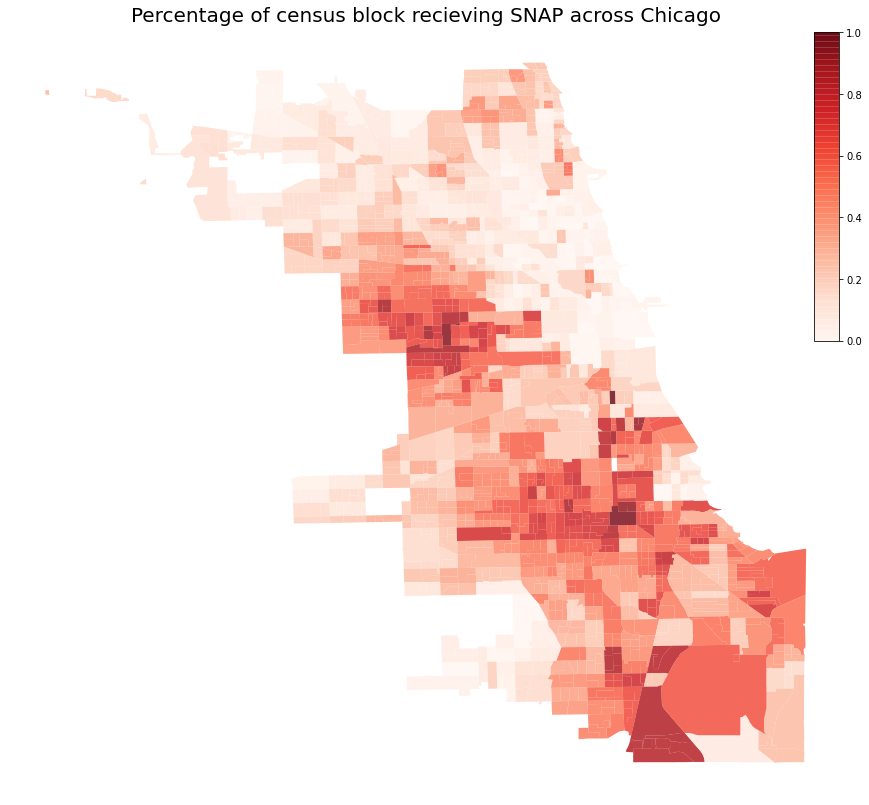

In [10]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import sys

fig, ax = plt.subplots(figsize=(15,15))
dissolved.plot(column='Percent_Received_SNAP',ax =ax, alpha=0.8, cmap='Reds')
ax.axis('off')


vmin, vmax = dissolved['Percent_Received_SNAP'].min(), dissolved['Percent_Received_SNAP'].max()

ax.set_title('Percentage of census block recieving SNAP across Chicago', fontdict={'fontsize': 20, 'fontweight' : 1})

axins1 = inset_axes(ax, width="3%", height="40%", loc='upper right')

sm = plt.cm.ScalarMappable(cmap='Reds')

sm._A = []
fig.colorbar(sm, cax=axins1, alpha=0.8)

plt.savefig('figure_outputs/percent_snap.png')


### Targets

In [11]:
df_targets_diff = pd.read_csv('./data/COVID_mobility_targets_adjusted.csv', dtype={'geo_12': 'int64'})
df_targets_diff.describe()

,geo_12,Week,fraction_of_devices_home_adj,fraction_of_devices_work_adj,avg_time_away_all_adj,avg_time_away_leave_adj
count,5.976600e+04,59766.000000,59766.000000,59766.000000,59766.000000,59766.000000
mean,1.703159e+11,14.999950,-0.211237,0.120848,1.096344,-0.314741
std,2.924231e+06,1.414172,0.101912,0.063296,1.335337,1.669014
min,1.703101e+11,13.000000,-0.605221,-0.205936,-13.076083,-13.564258
25%,1.703128e+11,14.000000,-0.277868,0.078572,0.430379,-1.112119
50%,1.703180e+11,15.000000,-0.213809,0.120028,1.174860,-0.171479
75%,1.703182e+11,16.000000,-0.146648,0.162863,1.887238,0.694143
max,1.703199e+11,17.000000,0.297790,0.380791,6.935266,7.579268


#### Split targets data by week

In [12]:
week_1 = df_targets_diff[df_targets_diff['Week']==13]
week_5 = df_targets_diff[df_targets_diff['Week']==17]

In [13]:
crs = 'epsg:4326'
merged_all = gpd.GeoDataFrame(df_targets_diff.merge(census_gdf, on="geo_12"), crs=crs)

#### Create geopandas dataframes

In [14]:
crs = 'epsg:4326'

merged_gdf_targets_week_1 = gpd.GeoDataFrame(week_1.merge(census_gdf, on="geo_12"), crs=crs)
merged_gdf_targets_week_5 = gpd.GeoDataFrame(week_5.merge(census_gdf, on="geo_12"), crs=crs)

In [15]:
dissolved_week1 = merged_gdf_targets_week_1.dissolve(by='geo_12')
dissolved_week5 = merged_gdf_targets_week_5.dissolve(by='geo_12')

In [16]:
dissolved_week1.describe()

,Week,fraction_of_devices_home_adj,fraction_of_devices_work_adj,avg_time_away_all_adj,avg_time_away_leave_adj
count,2185.0,2185.000000,2185.000000,2185.000000,2185.000000
mean,13.0,-0.164393,0.100555,0.428795,-0.964495
std,0.0,0.104674,0.062360,1.476857,1.844168
min,13.0,-0.484004,-0.198270,-12.529038,-13.297896
25%,13.0,-0.233406,0.058094,-0.236985,-1.846864
50%,13.0,-0.165622,0.102777,0.565090,-0.783034
75%,13.0,-0.100967,0.142571,1.318762,0.139799
max,13.0,0.229311,0.319916,4.869773,5.172535


Text(0, 0.5, 'count of census tracts')

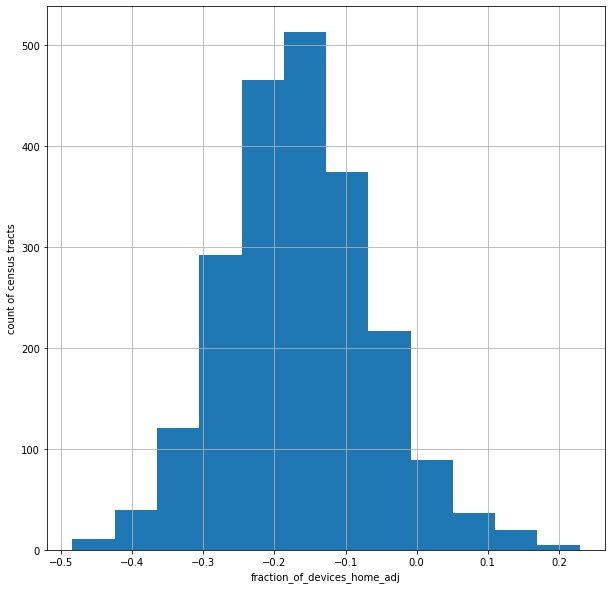

In [17]:
# plot distribution of targets
fig, ax = plt.subplots(figsize=(10,10))
dissolved_week1['fraction_of_devices_home_adj'].hist(bins=12)
plt.xlabel('fraction_of_devices_home_adj')
plt.ylabel('count of census tracts')

In [18]:
color_map = plt.cm.get_cmap('RdBu')
reversed_color_map = color_map.reversed()

/Users/caitlinloftus/Documents/UChicago/year_one/spring/machine_learning/covid-chicago-mobility/venv/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.
  if __name__ == '__main__':


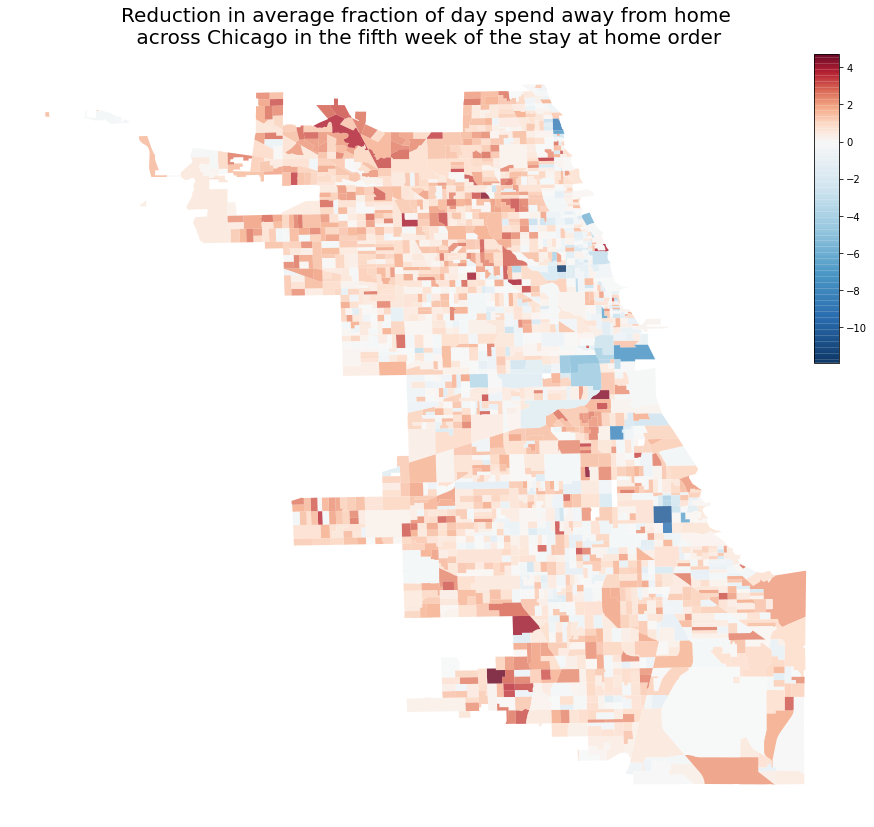

In [19]:
# Plot map of taget across Chicago
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.colors as colors
import sys

fig, ax = plt.subplots(figsize=(15,15))

vmin, vmax, vcenter = dissolved_week5['avg_time_away_all_adj'].min(), dissolved_week5['avg_time_away_all_adj'].max(), 0
divnorm = colors.DivergingNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

dissolved_week5.plot(column='avg_time_away_all_adj',ax =ax, alpha=0.8, cmap= reversed_color_map, norm=divnorm)

ax.axis('off')
ax.set_title('Reduction in average fraction of day spend away from home\n across Chicago in the fifth week of the stay at home order', fontdict={'fontsize': 20, 'fontweight' : 1})

axins1 = inset_axes(ax, width="3%", height="40%", loc='upper right')


sm = plt.cm.ScalarMappable(norm=divnorm, cmap=reversed_color_map)

sm._A = []
fig.colorbar(sm, cax=axins1, alpha=0.8)

plt.savefig('figure_outputs/fraction_time_away_all_adj_week5.png')


## Outliers analysis

In [32]:
outliers = dissolved_week1[dissolved_week1['avg_time_away_all_adj'] <= -7.5]

In [35]:
outliers_demographics = outliers.merge(df_features, on='geo_12')

In [44]:
outliers_demographics

,geo_12,geometry,Week,fraction_of_devices_home_adj,fraction_of_devices_work_adj,avg_time_away_all_adj,avg_time_away_leave_adj,statefp10,name10,blockce10,...,Percent_HS,Percent_SomeCollege,Percent_Bach,Percent_Grad,Percent_No_vehicals,Percent_Received_SNAP,Percent_Men_Usually_Fulltime_Employed,Percent_Women_Usually_Fulltime_Employed,Percent_No_Internet_Access,Percent_Computing_Device
0,170310104003,"POLYGON ((-87.65988 41.99820, -87.66001 41.998...",13,0.051293,0.072903,-11.820327,-13.009443,17,Block 3011,3011,...,0.112903,0.199309,0.410906,0.243856,0.230324,0.142931,0.360544,0.231325,0.000000,0.976331
1,170310301041,"POLYGON ((-87.65970 41.99638, -87.66022 41.996...",13,0.077194,0.093695,-12.529038,-13.297896,17,Block 1005,1005,...,0.141538,0.219692,0.309538,0.233231,0.352340,0.099813,0.420533,0.294426,0.073935,0.924812
2,170310710001,"POLYGON ((-87.65470 41.92172, -87.65495 41.921...",13,0.031138,0.121309,-12.076170,-12.495001,17,Block 1017,1017,...,0.042077,0.045902,0.614754,0.295082,0.231986,0.007007,0.273256,0.199315,0.085586,1.000000
3,170310810005,"POLYGON ((-87.63265 41.89661, -87.63279 41.896...",13,0.038883,0.102574,-7.987061,-9.683653,17,Block 5003,5003,...,0.116782,0.173844,0.359915,0.269715,0.552417,0.133303,0.449348,0.511745,0.255738,0.805464
4,170313204001,"POLYGON ((-87.62414 41.87316, -87.62414 41.873...",13,0.229311,0.068388,-7.963936,-7.331945,17,Block 1012,1012,...,0.017341,0.070328,0.303468,0.601156,0.261871,0.000000,0.319486,0.280809,0.000000,1.000000
5,170314203001,"POLYGON ((-87.59625 41.78234, -87.59624 41.781...",13,-0.001838,0.066124,-8.277777,-10.776983,17,Block 1005,1005,...,0.120042,0.281837,0.266180,0.296451,0.358263,0.213296,0.325871,0.266163,0.095568,0.916898
6,170318362001,"POLYGON ((-87.60119 41.78593, -87.60151 41.785...",13,0.080043,0.058029,-10.722681,-10.925121,17,Block 1010,1010,...,0.000000,0.050459,0.266055,0.683486,0.077586,0.000000,0.200258,0.161943,0.031746,1.000000
7,170318420002,"POLYGON ((-87.62529 41.83102, -87.62570 41.831...",13,0.015084,0.110341,-9.081594,-10.423030,17,Block 2009,2009,...,0.270475,0.221610,0.204405,0.185822,0.088167,0.081006,0.128740,0.120406,0.072289,1.000000


In [40]:
outliers_demographics_columns = ['geo_12','geometry', 'fraction_of_devices_work_adj','avg_time_away_all_adj',
       'Median_Income', 'Median_Age', 'Percent_NonCitizen',
       'Percent_SpeakEngl_Poorly', 'Percent_less_than_HS', 'Percent_HS',
       'Percent_SomeCollege', 'Percent_Bach', 'Percent_Grad',
       'Percent_No_vehicals', 'Percent_Received_SNAP',
       'Percent_Men_Usually_Fulltime_Employed',
       'Percent_Women_Usually_Fulltime_Employed', 'Percent_No_Internet_Access',
       'Percent_Computing_Device']

In [43]:
outliers_demographics[outliers_demographics_columns]

,geo_12,geometry,fraction_of_devices_work_adj,avg_time_away_all_adj,Median_Income,Median_Age,Percent_NonCitizen,Percent_SpeakEngl_Poorly,Percent_less_than_HS,Percent_HS,Percent_SomeCollege,Percent_Bach,Percent_Grad,Percent_No_vehicals,Percent_Received_SNAP,Percent_Men_Usually_Fulltime_Employed,Percent_Women_Usually_Fulltime_Employed,Percent_No_Internet_Access,Percent_Computing_Device
0,170310104003,"POLYGON ((-87.65988 41.99820, -87.66001 41.998...",0.072903,-11.820327,39167.0,20.6,0.058219,0.032945,0.033026,0.112903,0.199309,0.410906,0.243856,0.230324,0.142931,0.360544,0.231325,0.000000,0.976331
1,170310301041,"POLYGON ((-87.65970 41.99638, -87.66022 41.996...",0.093695,-12.529038,39224.0,21.8,0.142337,0.130533,0.096000,0.141538,0.219692,0.309538,0.233231,0.352340,0.099813,0.420533,0.294426,0.073935,0.924812
2,170310710001,"POLYGON ((-87.65470 41.92172, -87.65495 41.921...",0.121309,-12.076170,124444.0,19.8,0.049305,0.033229,0.002186,0.042077,0.045902,0.614754,0.295082,0.231986,0.007007,0.273256,0.199315,0.085586,1.000000
3,170310810005,"POLYGON ((-87.63265 41.89661, -87.63279 41.896...",0.102574,-7.987061,78047.0,24.5,0.096922,0.067471,0.079745,0.116782,0.173844,0.359915,0.269715,0.552417,0.133303,0.449348,0.511745,0.255738,0.805464
4,170313204001,"POLYGON ((-87.62414 41.87316, -87.62414 41.873...",0.068388,-7.963936,176000.0,21.2,0.132647,0.060082,0.007707,0.017341,0.070328,0.303468,0.601156,0.261871,0.000000,0.319486,0.280809,0.000000,1.000000
5,170314203001,"POLYGON ((-87.59625 41.78234, -87.59624 41.781...",0.066124,-8.277777,39091.0,20.7,0.108148,0.037288,0.035491,0.120042,0.281837,0.266180,0.296451,0.358263,0.213296,0.325871,0.266163,0.095568,0.916898
6,170318362001,"POLYGON ((-87.60119 41.78593, -87.60151 41.785...",0.058029,-10.722681,110357.0,19.9,0.129052,0.043887,0.000000,0.000000,0.050459,0.266055,0.683486,0.077586,0.000000,0.200258,0.161943,0.031746,1.000000
7,170318420002,"POLYGON ((-87.62529 41.83102, -87.62570 41.831...",0.110341,-9.081594,63958.0,21.0,0.217932,0.122824,0.117688,0.270475,0.221610,0.204405,0.185822,0.088167,0.081006,0.128740,0.120406,0.072289,1.000000
